# Stock price prediction using Linear Regression

This project is based on a tutorial from [Predicting Stock Prices with Python using Machine Learning - Linear Regression
](https://www.youtube.com/watch?v=AXBhrLongC8). The idea behind using linear regression to predict the stock price involves leveraging lagged returns data. The linear regression is fitted using lagged returns data as predictor variables and actual returns as a response variable. If the predicted return is positive, the asset is assumed to be bought/held and if the predicted return is negative, the asset is assumed to be shorted. 

Linear regression is one of the most primitive methods for stock price prediction. The coefficients in a linear regression model show how much of an impact each predictor in the model has, making it easier to understand the influence of historical data on future stock prices. Creating a linear regression model is computationally efficient, but it is not able to capture nonlinear behaviour of a stock price. However, it can serve as a good basis for understanding predictive models of the stock market, upon which more complicated predictive models could be built in the future.

## Additional analysis

In this notebook I added several minor additions to the initial analysis performed on the video from [Algovibes Youtube channel](https://www.youtube.com/@Algovibes)

- Added a scatter plot of predicted and actual results
- Calculated MAE, MSE and RMSE values
- Calculated residuals and plotted their distribution
- Assessed whether residual distribution is normally distributed and general performance of the model

## Dataset

The dataset utilized in this analysis was downloaded using the yfinance library, which allows easy access to historical market data from Yahoo Finance. The asset, which can be a cryptocurrency, stock, or any other financial instrument, can be chosen on user preference, as well as the start and end dates.

In this case, the S&P 500 index was analysed during the period between 3rd of January 2010 and 17th of June 2024. The dataset consists of 3637 records, with each record representing prices and volume at that trading day. Initially, only 'Close' column will be used for the price analysis of the stock. Additional columns relevant to analysis will be added based on the information contained in the 'Close' column. 

In [43]:
# Import relevant libraries

import yfinance as yf 
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
import pylab
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [44]:
df = yf.download('^GSPC', start = '2010-01-01', end = '2024-06-17') # Choose any stock/crypto and the start/finish date
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000
...,...,...,...,...,...,...
2024-06-10,5341.220215,5365.790039,5331.520020,5360.790039,5360.790039,3622280000
2024-06-11,5353.000000,5375.950195,5327.250000,5375.319824,5375.319824,3568030000
2024-06-12,5409.129883,5447.250000,5409.129883,5421.029785,5421.029785,3962840000


Logarithmic returns of the asset were then calculated, because of their addtive and symmetric properties and a new column for returns was appended to the dataset in the code below.

In [45]:
df['returns'] = np.log(df.Close.pct_change() + 1) # make logged returns, as they have additive and symmetric properties of the asset

Lagged returns columns were then added to the dataset, based on which the linear regression model would be fit.

In [46]:
def lagit(df, lags): # function that creates lagged columns for the based on the specified number of lags
    names = []
    for i in range(1, lags + 1):
        df['Lag_'+str(i)] = df['returns'].shift(i)
        names.append('Lag_'+str(i))
    return names

In [47]:
lagnames = lagit(df, 5) # create specified number of lagged columns and append them to the dataset
df

,Open,High,Low,Close,Adj Close,Volume,returns,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5
Date,,,,,,,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,0.003111,NaN,NaN,NaN,NaN,NaN
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,0.000545,0.003111,NaN,NaN,NaN,NaN
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,0.003993,0.000545,0.003111,NaN,NaN,NaN
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,0.002878,0.003993,0.000545,0.003111,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-10,5341.220215,5365.790039,5331.520020,5360.790039,5360.790039,3622280000,0.002578,-0.001116,-0.000200,0.011778,0.001502,0.001115
2024-06-11,5353.000000,5375.950195,5327.250000,5375.319824,5375.319824,3568030000,0.002707,0.002578,-0.001116,-0.000200,0.011778,0.001502
2024-06-12,5409.129883,5447.250000,5409.129883,5421.029785,5421.029785,3962840000,0.008468,0.002707,0.002578,-0.001116,-0.000200,0.011778


In [48]:
df.dropna(inplace = True) # Drop missing values of lagged returns columns

In [49]:
model = LinearRegression() # define linear regression function

model.fit(df[lagnames], df['returns']) # Fit linear regression to lagged returns as predictor vriables and returns as a response variable

LinearRegression()

The lagged coefficients for each return variable turned out to be pretty small, because the scale is really small compared to the overall return value range within the dataset. 

In [50]:
cdf = pd.DataFrame(model.coef_, lagnames, columns = ['Coefficients']) # Calculate the coefficients of each lagged return variable
print(cdf)

       Coefficients
Lag_1     -0.111140
Lag_2      0.058941
Lag_3     -0.023571
Lag_4     -0.046357
Lag_5     -0.001737


Three columns with predicted variables, the direction of change (1 for increase and -1 for decrease) and the amount by which returns decreased/increased were created and appended to the original dataset.

In [51]:
df['prediction_LR'] = model.predict(df[lagnames])
df['direction_LR'] = [1 if i > 0 else -1 for i in df.prediction_LR]
df['strat_LR'] = df['direction_LR'] * df['returns']

The cumulative returns of the investment on the asset by just holding and with linear regression method were then calculated. As can be seen, the linear regression method strongly outperfroms just holding the investment. Note that this model was trained on all of the retrieved data.

In [52]:
np.exp(df[['returns', 'strat_LR']].sum())

returns     4.735567
strat_LR    7.218456
dtype: float64

The performance of both investment methods can be seen on the graph below. This linear model is clearly overfitted, as all the data retrieved from yfinance was used to fit the regression to the data. In order to test how well linear regression predicts the stock data, the dataset should be split into training and testing parts, then trained and tested accordingly.

<Axes: xlabel='Date'>

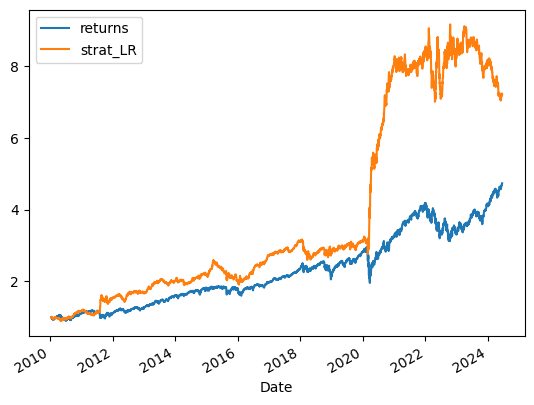

In [53]:
np.exp(df[['returns', 'strat_LR']].cumsum()).plot()

In [54]:
train, test = train_test_split(df, shuffle = False, test_size = 0.3, random_state = 42) # Create a train/test split to test the performance of the model

In [55]:
model.fit(train[lagnames], train['returns'].dropna()) # fit the training dataset to the model and drop the missing values

LinearRegression()

In [56]:
test['prediction_LR'] = model.predict(test[lagnames])  # Create same columns for the testing dataset in order to evaluate performance of the function.
test['direction_LR'] = [1 if i > 0 else - 1 for i in test['prediction_LR']]
test['strat_LR'] = test['direction_LR'] * test['returns']

After splitting the dataset into training and testing parts, it can be seen that the performance of the linear regression method changed. However, the shorter time horizon and specific economic events during specified time range should be also taken into the consideration, as these factors will have a quite strong impact on the returns on investment. 

In [57]:
np.exp(test[['returns', 'strat_LR']].sum()) # Check the returns with and without linear regression

returns     1.606906
strat_LR    1.776865
dtype: float64

<Axes: xlabel='Date'>

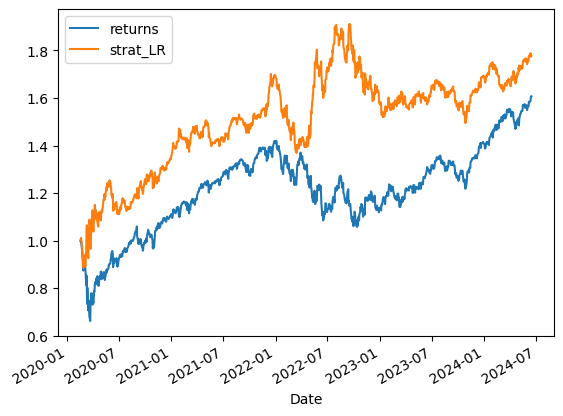

In [58]:
np.exp(test[['returns', 'strat_LR']].cumsum()).plot() # Visualize results

The number of trades required in specific case is then calculated by taking the difference of the direction column every time the change occurs.

In [59]:
print('Number of required trades:', (test['direction_LR'].diff() != 0).value_counts()[True]) # show number of times there was a change in stock price smovement direction

Number of required trades: 494


Now let's plot the results predicted using linear regression method against the actual results. If the linear regression model performs well, the points should be alligned across the horizontal line, indicating linear relationship between predicted and actual values. 

As can be seen from the graph below, there is almost no distinct linear relationship between the predicted and actual values. Occasional outliers can be seen as individual points located far away from the general distribution, indicating days where predicted and actual returns differed drastically.

Text(0.5, 1.0, 'Comparison of predicted and actual results using LR')

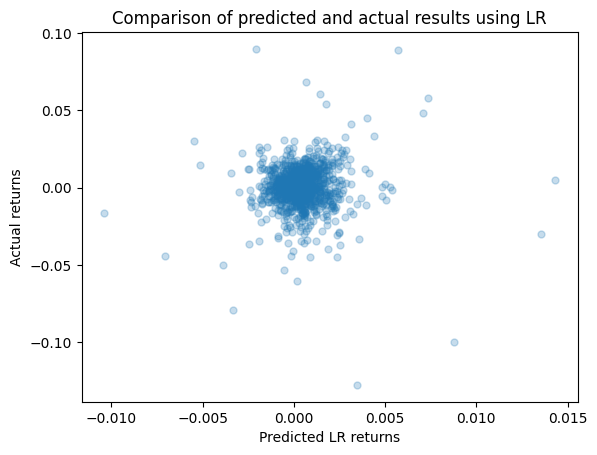

In [60]:
plt.scatter(test['prediction_LR'], test['returns'], s = 25, alpha = 0.25) # initiate plotting scatterplot
plt.xlabel('Predicted LR returns')
plt.ylabel('Actual returns')
plt.title('Comparison of predicted and actual results using LR')

The MAE, MSE and RMSE values were then calculated and turned out to be very small, because of the log return values scale. The percentage value would show the significance of these values better.

As can be seen below, the MAE, MSE and RMSE values are bigger than the mean in majority of cases. This is due to the fact that linear regression is not able to predict extreme economic events and the non-linear behaviour of the stock price itself.

In [61]:
print('Mean Absolute Error:', mean_absolute_error(test['returns'], test['prediction_LR']).round(6))
print('Mean Squared Error:', mean_squared_error(test['returns'], test['prediction_LR']).round(6))
print('Root Mean Squared Error:', round(math.sqrt(mean_squared_error(test['returns'], test['prediction_LR'])), 6))

print('-' * 50)  # Separate lines

mean_returns = np.mean(test['returns'])
print('Mean Returns:', mean_returns)

print('-' * 50)  # Separate lines

print('Mean Absolute Error (in %):', (mean_absolute_error(test['returns'], test['prediction_LR']) / mean_returns * 100).round(2), '%')
print('Mean Squared Error (in %):', (mean_squared_error(test['returns'], test['prediction_LR']) / mean_returns * 100).round(2), '%')
print('Root Mean Squared Error (in %):', (math.sqrt(mean_squared_error(test['returns'], test['prediction_LR'])) / mean_returns * 100).round(2), '%')


Mean Absolute Error: 0.009245
Mean Squared Error: 0.000199
Root Mean Squared Error: 0.01411
--------------------------------------------------
Mean Returns: 0.00043514747538626924
--------------------------------------------------
Mean Absolute Error (in %): 2124.63 %
Mean Squared Error (in %): 45.75 %
Root Mean Squared Error (in %): 3242.49 %


The residual values are then calculated by taking a difference of actual return values and predicted values. One of the assumptions of the linear regression model is that residual values should have normal distribution, as it allows us to make valid statistical inferences about the coefficients. 

As can be seen on the graph below, the obtained distribution looks really close to normal.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(-0.07, 0.07)

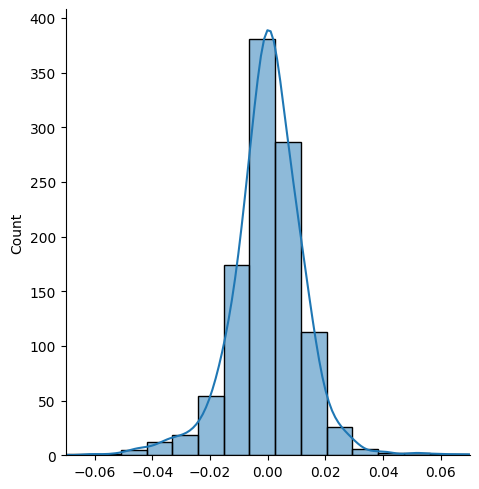

In [62]:
residuals = test['returns'] - test['prediction_LR']
sns.displot(residuals, bins = 25, kde = True)
plt.xlim(-0.07, 0.07)

The better way to check whether residuals have normal distribution is to plot the QQ plot. QQ plot is a type of scatter plot with quantiles of one dataset against the respective quantiles of chosen distribution. When both datasets come from the same distribution, the points in the plot are expected to align approximately along a straight line.

As can be seen from the plot below, the points allign nearly perfectly along the middle of the straight line. However, towards the beginning the and end of the straight line, slight deviations can be observed, indicating the distribution has skewed tails and outliers are present towards both of ends of the returns axis.

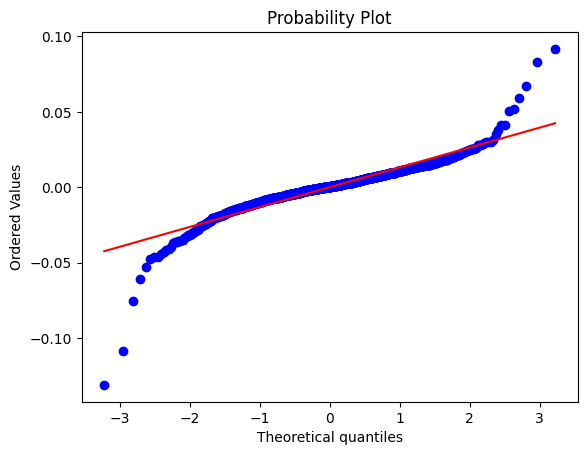

In [63]:
stats.probplot(residuals, dist = 'norm', plot = pylab)
pylab.show()

## Conclusion

This notebook applies linear regression to predict stock prices using lagged return data, following a tutorial on "Predicting Stock Prices with Python using Machine Learning - Linear Regression". The historical price data of S&P 500 index between January 3, 2000, and June 17, 2024 was used for the analysis. Logarithmic returns of the S&P 500 index price were calculated due to their standardization properties, and lagged returns were used for fitting linear regression model. It is important to note theat linear regression's performance can vary significantly depending on the chosen date range.

The model's predictive accuracy was evaluated using metrics like Mean Absolute Error (MAE) and Mean Squared Error (MSE). These metrics turned out to be pretty small due to the scale of log returns. The percentage of the error metrics relative to the return mean value were then computed to assess their influence. They turned out to be relatively big, including 2124% for MAE, 45% for MSE and 3242% for RMSE, which shows that linear regression model has very poor predictive ability for the stock price. This is due to the non-linear nature of the stock market, and also events of rapid growth/fall of the index price. After analysing various assets with this model and different time ranges, a basic trading strategy using buy-and-hold appears to be superior in comparison to linear regression model. 